# 🧠 MarocExplorer_Modèle  

Bienvenue dans le notebook **MarocExplorer_Modèle** !  
Ce projet vise à tester et évaluer différents modèles pour la prédiction des **coordonnées géographiques** à partir d'images marocaines enrichies de métadonnées.  

---

## 💡 Contexte  
Le projet **MarocExplorer** a pour objectif de développer un modèle capable de **géolocaliser des images marocaines** en utilisant à la fois leurs **caractéristiques visuelles** et les **informations contextuelles** des villes.  
Après avoir construit et enrichi notre **dataset d'images géolocalisées**, il est temps de passer à la **phase de modélisation**.  

---

## 📊 Objectifs du Notebook  
Ce notebook est consacré à la **sélection, l'entraînement et l'évaluation des modèles** pour le projet **MarocExplorer**. Il s'articule autour des étapes suivantes :  

1. **Présentation des modèles candidats** : Exploration des architectures et choix des hyperparamètres.  
2. **Préparation des données** : Transformation des images et traitement des métadonnées.  
3. **Entraînement des modèles** : Application d'une procédure uniforme pour garantir l'équité de la comparaison.  
4. **Évaluation des performances** : Analyse des résultats à l'aide de métriques pertinentes.  
5. **Benchmark** : Comparaison des performances pour sélectionner le meilleur modèle.  

---

## 📝 Pourquoi ce Notebook ?  
Ce notebook constitue une étape essentielle pour sélectionner le modèle le plus performant et le mieux adapté aux **données géolocalisées marocaines**.  
Il documente l'ensemble du **processus de modélisation**, des choix d'architecture aux résultats finaux, afin d'assurer la **reproductibilité** et la **comparabilité** des performances.  

---

## 🚀 Structure du Notebook  
- **Partie 1** : Présentation des modèles et choix des architectures.  
- **Partie 2** : Préparation des données d'entraînement et de validation.  
- **Partie 3** : Entraînement des modèles avec un protocole uniforme.  
- **Partie 4** : Évaluation des performances et analyse des résultats.  
- **Partie 5** : Benchmark et sélection du meilleur modèle.  

---

🔧 **Commençons !**  


# Présentation des modèles

In [ ]:
#@title importation des bibliothèques
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm  # Pour accéder facilement à DenseNet121
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')

In [ ]:
#@title Configuration

# Remplacez les chemins par ceux de votre environnement
images_folder = '/kaggle/input/data-morroco/Data_maroc/images' # Dossier qui contient les images
csv_path = '/kaggle/input/data-morroco/Data_maroc/maroc_data_finale.csv' # Dossier csv des cordonnées des images et les villes
city_features_path = '/kaggle/input/data-morroco/Data_maroc/M_villes_avec_coords.csv' # Dossier des métadonnées des villes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}") # Détection  de l'appareil pour l'entraînement

In [ ]:
#@title  Haversine distance pour évaluer les prédictions
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcule la distance du grand cercle entre deux points
    sur la terre (spécifiés en degrés décimaux)
    """
    # Conversion des degrés décimaux en radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Formule de Haversine
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Rayon de la terre en kilomètres
    return c * r

In [ ]:
#@title Hyperparamètres communs

learning_rate = 1e-4
# Pour l'optimizer c'est ADAM
batch_size = 32
num_epochs = 15
loss_function = "MSE"
proportion_train = 0.8

# Dimensions cachées pour les caractéristiques de ville
city_hidden_dim1 = 128
city_hidden_dim2 = 74
dropout_city1 = 0.3

# Dimensions pour la régression combinée
regression_dim1 = 512
regression_dim2 = 128
dropout_reg1 = 0.3
dropout_reg2 = 0.2


# Préparation des données

**Préparation des MétaDonnées supplémentaires :**

La fonction `prepare_city_features` a pour objectif de préparer les données géographiques supplémentaires associées aux images.  
Elle permet de transformer les **caractéristiques catégorielles** et **numériques** des villes pour les rendre exploitables par le modèle.

Étapes de la fonction :

1. **Chargement des données :**  
   - Lecture du fichier CSV contenant les informations géographiques et urbaines des villes.  
   
2. **Encodage des caractéristiques catégorielles :**  
   - Les colonnes contenant des informations qualitatives (par exemple, `Architecture`, `Climat`, `Points_intérêt`) sont encodées à l'aide de l'encodeur `LabelEncoder` de `sklearn`.  
   
3. **Normalisation des caractéristiques numériques :**  
   - La colonne `Distance_côte` est normalisée avec `StandardScaler` pour rendre les valeurs comparables.  

4. **Sélection des colonnes pertinentes :**  
   - Les caractéristiques sélectionnées incluent les données encodées et normalisées, ainsi que la ville et ses coordonnées géographiques (`lat`, `lng`).  

5. **Gestion des erreurs :**  
   - En cas d'échec lors du chargement ou du traitement des données, un message d'erreur est affiché, et le modèle d'image seul est utilisé.  

In [ ]:
#@title Préparation des données supplémentaires
def prepare_city_features(city_features_path):
    try:
        city_features = pd.read_csv(city_features_path)

        # Encodage des caractéristiques catégorielles
        categorical_cols = ['Architecture', 'Terrain', 'Climat', 'Eau_proche',
                           'Montagne', 'Taille', 'Points_intérêt', 'Grande_ville_proche']

        for col in categorical_cols:
            le = LabelEncoder()
            city_features[col] = le.fit_transform(city_features[col])

        # Normalisation des caractéristiques numériques
        numerical_cols = ['Distance_côte']
        scaler = StandardScaler()
        city_features[numerical_cols] = scaler.fit_transform(city_features[numerical_cols])

        # Sélection des caractéristiques à utiliser
        feature_cols = categorical_cols + numerical_cols
        city_features = city_features[['Ville'] + feature_cols + ['lat', 'lng']]

        print(f"Number of cities with features: {len(city_features)}")
        return city_features, feature_cols
    except Exception as e:
        print(f"Error loading city features: {e}")
        print("Continuing with image-only model...")
        return None, None

In [ ]:
#@title Transformations d'images
transform = transforms.Compose([
    transforms.Resize(256), # taille uniforme de 256x256
    transforms.CenterCrop(224), # Recadrer en 224x224
    transforms.ToTensor(), # Convertir l'image en tenseur PyTorch
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalisation avec les moyennes et écarts-types d'ImageNet
])


**Pourquoi appliquer ces transformations ?**

Pour garantir une bonne compatibilité avec les modèles préentraînés (comme ResNet ou DenseNet), il est essentiel de préparer les images de manière cohérente.  
Les transformations suivantes sont appliquées pour standardiser les images et faciliter leur traitement par les modèles :  

- **Redimensionnement** : Les images sont redimensionnées à une taille uniforme de 256x256 pour garantir une entrée cohérente dans le pipeline.  
- **Recadrage centré** : Un recadrage centré de 224x224 est appliqué pour extraire la partie centrale de l'image, compatible avec les modèles ImageNet.  
- **Conversion en tenseur** : Les images sont converties en tenseurs PyTorch pour pouvoir être traitées par les modèles de deep learning.  
- **Normalisation** : Les canaux RGB sont normalisés avec les moyennes et écarts-types d'ImageNet pour que les données aient une distribution similaire aux images d'origine du modèle préentraîné.  


In [ ]:
#@title Dataset preparation
class ImageGPSDataset(Dataset):
    def __init__(self, csv_file, images_folder, city_features, feature_cols, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.images_folder = images_folder
        self.transform = transform
        self.city_features = city_features
        self.feature_cols = feature_cols

        # Obtenir la liste des images dans le dossier
        self.image_files = []
        for root, _, files in os.walk(self.images_folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_files.append(os.path.join(root, file))

        # Créer un dictionnaire pour accéder facilement aux chemins d'images par ID
        self.id_to_path = {}
        for img_path in self.image_files:
            img_id = os.path.splitext(os.path.basename(img_path))[0]
            self.id_to_path[img_id] = img_path

        # Filtrer les données pour ne conserver que les ID qui existent dans le dossier
        self.data_frame = self.data_frame[self.data_frame['id'].astype(str).isin(self.id_to_path.keys())]

        # S'assurer que chaque image a une ville associée dans le dataframe
        print(f"Initial number of images: {len(self.data_frame)}")
        self.data_frame = self.data_frame.dropna(subset=['city'])
        print(f"Number of images after removing null cities: {len(self.data_frame)}")

        # Fusionner avec les caractéristiques des villes - toujours utiliser inner join
        before_merge = len(self.data_frame)
        self.data_frame = pd.merge(self.data_frame, city_features,
                                 left_on='city', right_on='Ville', how='inner')
        after_merge = len(self.data_frame)

        # Afficher le nombre d'images éliminées car leur ville n'a pas de métadonnées
        print(f"Images removed due to missing city metadata: {before_merge - after_merge}")

        # Vérifier qu'il n'y a plus de données manquantes
        missing = self.data_frame[self.feature_cols].isna().any(axis=1).sum()
        if missing > 0:
            print(f"Warning: There are still {missing} rows with missing features after inner join")
            # Éliminer ces lignes également
            self.data_frame = self.data_frame.dropna(subset=self.feature_cols)
            print(f"Final number of images after removing all missing data: {len(self.data_frame)}")

        print(f"Final number of images in dataset: {len(self.data_frame)}")

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_id = str(self.data_frame.iloc[idx]['id'])
        latitude = float(self.data_frame.iloc[idx]['latitude'])
        longitude = float(self.data_frame.iloc[idx]['longitude'])

        # Ouvrir l'image depuis le dossier
        img_path = self.id_to_path[img_id]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Toujours inclure les caractéristiques de la ville
        city_feats = self.data_frame.iloc[idx][self.feature_cols].values.astype(np.float32)

        return {
            'id': img_id,
            'image': image,
            'coordinates': torch.tensor([latitude, longitude], dtype=torch.float),
            'latitude': latitude,
            'longitude': longitude,
            'city_features': torch.tensor(city_feats, dtype=torch.float)
        }

**Préparation du Dataset :**

Pour entraîner un modèle capable de prédire les coordonnées géographiques à partir d'images, il est crucial de structurer les données de manière efficace.  
Nous utilisons ici une classe personnalisée `ImageGPSDataset` pour gérer l'association entre les images, leurs coordonnées GPS, et éventuellement des **caractéristiques de ville**.  

Objectifs de la classe `ImageGPSDataset`

- **Chargement des données** : Lire les informations depuis un fichier CSV et organiser les chemins d'images.  
- **Gestion des images** : Vérifier la présence des images dans le dossier spécifié et créer un dictionnaire pour un accès rapide aux fichiers.  
- **Intégration des caractéristiques de ville** : Fusionner les informations des villes avec les images si elles sont disponibles.  
- **Prétraitement** : Traiter les valeurs manquantes en appliquant la moyenne pour les données numériques et la valeur la plus fréquente pour les données catégorielles.  
- **Accès aux échantillons** : Permettre un accès direct aux données avec `__getitem__`.  

Caractéristiques de la classe  

- **Gestion dynamique des images** : Filtre uniquement les images disponibles dans le dossier.  
- **Fusion de données** : Vérifie la présence des informations de ville et les intègre aux images si elles sont disponibles.  
- **Traitement des valeurs manquantes** : Prévoit des valeurs par défaut pour assurer la cohérence du dataset.  
- **Compatibilité PyTorch** : Les images et les coordonnées sont converties en tenseurs pour l'entraînement.  
- **Affichage des informations** : Nombre d'images disponibles après la vérification et fusion des données.  

Points d'attention

- **Vérification des données manquantes** : Signale les villes pour lesquelles les caractéristiques ne sont pas trouvées.  
- **Gestion d'erreurs** : La classe est robuste aux erreurs liées aux données manquantes et aux formats non conformes.  
- **Extension possible** : La classe peut être facilement adaptée pour ajouter d'autres types de métadonnées.  


In [ ]:
#@title fonctions d'entraînement et de validation
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc="Training"):
        images = batch['image'].to(device)
        coordinates = batch['coordinates'].to(device)
        city_features = batch['city_features'].to(device)

        optimizer.zero_grad()

        # Toujours utiliser city_features
        outputs = model(images, city_features)

        loss = criterion(outputs, coordinates)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(train_loader.dataset)

def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_distances = []
    all_true_coords = []
    all_pred_coords = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            images = batch['image'].to(device)
            coordinates = batch['coordinates'].to(device)
            city_features = batch['city_features'].to(device)

            # Toujours utiliser city_features
            outputs = model(images, city_features)

            loss = criterion(outputs, coordinates)

            running_loss += loss.item() * images.size(0)

            pred_coords = outputs.cpu().numpy()
            true_coords = coordinates.cpu().numpy()

            all_pred_coords.append(pred_coords)
            all_true_coords.append(true_coords)

            pred_lat, pred_lon = pred_coords.T
            true_lat, true_lon = true_coords.T

            for i in range(len(pred_lat)):
                distance = haversine_distance(pred_lat[i], pred_lon[i], true_lat[i], true_lon[i])
                all_distances.append(distance)

    # Concatenate all predictions and ground truth
    all_pred_coords = np.concatenate(all_pred_coords, axis=0)
    all_true_coords = np.concatenate(all_true_coords, axis=0)

    # Calculate metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    mean_distance = np.mean(all_distances)
    median_distance = np.median(all_distances)

    # Calculate R² for latitude and longitude separately
    r2_lat = r2_score(all_true_coords[:, 0], all_pred_coords[:, 0])
    r2_lon = r2_score(all_true_coords[:, 1], all_pred_coords[:, 1])
    r2_combined = (r2_lat + r2_lon) / 2  # Average R² for both coordinates

    # Calculate MSE
    mse = mean_squared_error(all_true_coords, all_pred_coords)

    return epoch_loss, mean_distance, median_distance, r2_combined, mse

La fonction `train_model` est utilisée pour entraîner notre modèle sur les données d'entraînement. Elle prend en entrée le modèle, le chargeur de données d'entraînement, la fonction de perte, l'optimiseur et l'appareil (CPU ou GPU). L'option `use_city_features` permet d'intégrer les caractéristiques des villes si elles sont disponibles. La fonction commence par activer le mode entraînement avec `model.train()`, puis parcourt les lots de données. Pour chaque lot, elle transfère les images et les coordonnées sur le bon appareil, réinitialise les gradients et effectue la prédiction. Si les caractéristiques des villes sont utilisées, elles sont également transférées et ajoutées à la prédiction. La perte est calculée, rétropropagée et l'optimiseur met à jour les poids du modèle. La fonction retourne la perte moyenne sur l'ensemble du dataset.  
- Mode entraînement activé pour ajuster les poids.  
- Gestion des données avec ou sans caractéristiques de ville.  
- Calcul de la perte avec rétropropagation pour la mise à jour des poids.  

La fonction `validate_model` permet d'évaluer les performances du modèle sur les données de validation. Elle utilise les mêmes paramètres que la fonction d'entraînement, mais fonctionne en mode évaluation (`model.eval()`) pour désactiver les calculs de gradient. La fonction prédit les coordonnées à partir des images et, si disponible, des caractéristiques de ville. Elle calcule ensuite la perte et des métriques d'évaluation, notamment l'erreur quadratique moyenne (MSE), la distance moyenne et médiane, et le coefficient de détermination R² pour les coordonnées. Ces mesures permettent d'évaluer la précision géographique du modèle. Les résultats sont retournés sous forme de métriques pour un suivi des performances.  
- Mode évaluation pour désactiver les gradients et optimiser les calculs.  
- Calcul des métriques de précision géographique (MSE, R², distances).  
- Gestion des erreurs et agrégation des résultats pour une analyse des performances.  


# Modèles

## Architecture du modèle

Notre approche repose sur l’idée d’utiliser un modèle préentraîné pour extraire les caractéristiques visuelles des images. Ensuite, nous ajoutons des couches supplémentaires afin d’intégrer également les données géographiques (villes, régions, etc.) et de transformer la tâche en un problème de régression, avec pour cibles les coordonnées latitude et longitude.

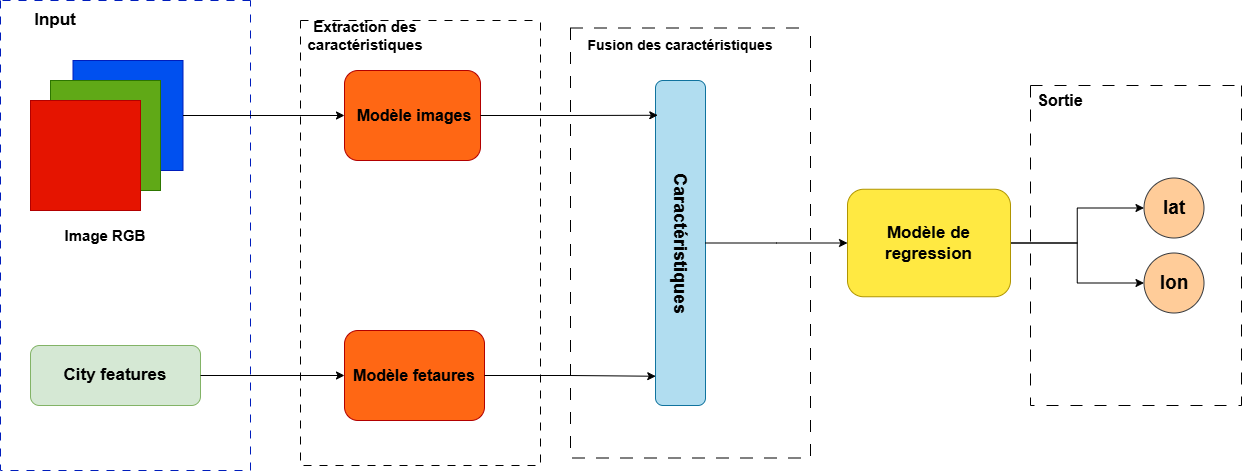

## Création des modèles condidat

In [ ]:
#@title Densenet121
class DenseNetGPSModel(nn.Module):
    def __init__(self, num_city_features):
        super(DenseNetGPSModel, self).__init__()

        # DenseNet121 comme extracteur de caractéristiques
        self.densenet = timm.create_model('densenet121', pretrained=True, num_classes=0)

        # Gel des premières couches pour un entraînement plus rapide et prévenir le surapprentissage
        # DenseNet121 a une structure différente d'EfficientNet
        for name, param in self.densenet.named_parameters():
            if 'denseblock4' not in name and 'norm5' not in name:
                param.requires_grad = False

        # Nombre de caractéristiques de sortie du DenseNet121
        densenet_features = 1024  # DenseNet121 a 1024 caractéristiques de sortie

        # Traitement des caractéristiques de ville
        self.city_features_processor = nn.Sequential(
            nn.Linear(num_city_features, city_hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_city1),
            nn.Linear(city_hidden_dim1, city_hidden_dim2),
            nn.ReLU()
        )
        combined_features = densenet_features + city_hidden_dim2

        # Régression combinée
        self.regression = nn.Sequential(
            nn.Linear(combined_features, regression_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_reg1),
            nn.Linear(regression_dim1, regression_dim2),
            nn.ReLU(),
            nn.Dropout(dropout_reg1),
            nn.Linear(regression_dim2, 2)  # Sortie: [latitude, longitude]
        )

    def forward(self, image, city_features):
        # Traitement de l'image
        image_feats = self.densenet(image)

        # Traitement des caractéristiques de ville
        city_feats = self.city_features_processor(city_features)

        # Combinaison des caractéristiques
        combined = torch.cat((image_feats, city_feats), dim=1)

        # Prédiction des coordonnées
        coordinates = self.regression(combined)

        return coordinates

In [ ]:
#@title Efficientnet_b0
class EfficientNetGPSModel(nn.Module):
    def __init__(self, num_city_features):
        super(EfficientNetGPSModel, self).__init__()

        # EfficientNet B0 comme extracteur de caractéristiques
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)

        # Gel des premières couches pour un entraînement plus rapide et prévenir le surapprentissage
        for name, param in self.efficientnet.named_parameters():
            if 'blocks.6' not in name and 'conv_head' not in name and 'bn2' not in name:
                param.requires_grad = False

        efficientnet_features = 1280  # EfficientNet B0 a 1280 caractéristiques de sortie

        # Traitement des caractéristiques de ville
       self.city_features_processor = nn.Sequential(
            nn.Linear(num_city_features, city_hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_city1),
            nn.Linear(city_hidden_dim1, city_hidden_dim2),
            nn.ReLU()
        )
        combined_features = efficientne + city_hidden_dim2

        # Régression combinée
        self.regression = nn.Sequential(
            nn.Linear(combined_features, regression_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_reg1),
            nn.Linear(regression_dim1, regression_dim2),
            nn.ReLU(),
            nn.Dropout(dropout_reg1),
            nn.Linear(regression_dim2, 2)  # Sortie: [latitude, longitude]
        )

    def forward(self, image, city_features):
        # Traitement de l'image
        image_feats = self.efficientnet(image)

        # Traitement des caractéristiques de ville
        city_feats = self.city_features_processor(city_features)

        # Combinaison des caractéristiques
        combined = torch.cat((image_feats, city_feats), dim=1)

        # Prédiction des coordonnées
        coordinates = self.regression(combined)

        return coordinates

In [ ]:
#@title Resnet50
class ResNet50GPSModel(nn.Module):
    def __init__(self, num_city_features):
        super(ResNet50GPSModel, self).__init__()

        # ResNet50 comme extracteur de caractéristiques
        self.resnet = timm.create_model('resnet50', pretrained=True, num_classes=0)

        # Gel des premières couches pour un entraînement plus rapide et prévenir le surapprentissage
        for name, param in self.resnet.named_parameters():
            if 'layer4' not in name and 'fc' not in name:
                param.requires_grad = False

        # Nombre de caractéristiques de sortie du ResNet50
        resnet50_features = 2048  # ResNet50 a 2048 caractéristiques de sortie

        # Traitement des caractéristiques de ville
        self.city_features_processor = nn.Sequential(
            nn.Linear(num_city_features, city_hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_city1),
            nn.Linear(city_hidden_dim1, city_hidden_dim2),
            nn.ReLU()
        )
        combined_features = resnet50_features + city_hidden_dim2

        # Régression combinée
        self.regression = nn.Sequential(
            nn.Linear(combined_features, regression_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_reg1),
            nn.Linear(regression_dim1, regression_dim2),
            nn.ReLU(),
            nn.Dropout(dropout_reg1),
            nn.Linear(regression_dim2, 2)  # Sortie: [latitude, longitude]
        )

    def forward(self, image, city_features):
        # Traitement de l'image
        image_feats = self.resnet(image)

        # Traitement des caractéristiques de ville
        city_feats = self.city_features_processor(city_features)

        # Combinaison des caractéristiques
        combined = torch.cat((image_feats, city_feats), dim=1)

        # Prédiction des coordonnées
        coordinates = self.regression(combined)

        return coordinates

In [ ]:
#@title Resnet18
class ResNet18GPSModel(nn.Module):
    def __init__(self, num_city_features):
        super(ResNet18GPSModel, self).__init__()

        # ResNet18 comme extracteur de caractéristiques
        self.resnet = timm.create_model('resnet18', pretrained=True, num_classes=0)

        # Gel des premières couches pour un entraînement plus rapide et prévenir le surapprentissage
        for name, param in self.resnet.named_parameters():
            if 'layer4' not in name and 'fc' not in name:
                param.requires_grad = False

        # Nombre de caractéristiques de sortie du ResNet18
        resnet18_features = 512  # ResNet18 a 2048 caractéristiques de sortie

        # Traitement des caractéristiques de ville
        self.city_features_processor = nn.Sequential(
            nn.Linear(num_city_features, city_hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_city1),
            nn.Linear(city_hidden_dim1, city_hidden_dim2),
            nn.ReLU()
        )
        combined_features = resnet18_features + city_hidden_dim2

        # Régression combinée
        self.regression = nn.Sequential(
            nn.Linear(combined_features, regression_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_reg1),
            nn.Linear(regression_dim1, regression_dim2),
            nn.ReLU(),
            nn.Dropout(dropout_reg1),
            nn.Linear(regression_dim2, 2)  # Sortie: [latitude, longitude]
        )

    def forward(self, image, city_features):
        # Traitement de l'image
        image_feats = self.resnet(image)

        # Traitement des caractéristiques de ville
        city_feats = self.city_features_processor(city_features)

        # Combinaison des caractéristiques
        combined = torch.cat((image_feats, city_feats), dim=1)

        # Prédiction des coordonnées
        coordinates = self.regression(combined)

        return coordinates

# Entrainement

## Essai d'esntrainement sans l'utilsation des métadonnées

**Entraînement avec ResNet18 sans les caractéristiques des villes**  

Pour évaluer l'impact des **caractéristiques des villes** sur la précision du modèle, nous allons d'abord entraîner **ResNet18** en **ignorant ces informations**.  
Cela nous permettra de comparer les résultats obtenus avec et sans l'utilisation des **features géographiques** et de mesurer leur **importance** dans la tâche de régression des coordonnées.  


In [ ]:
#@title Modèle ResNet18 simplifié - image uniquement
class ResNetGPSModel(nn.Module):
    def __init__(self):
        super(ResNetGPSModel, self).__init__()

        # ResNet18 comme extracteur de caractéristiques
        self.resnet = timm.create_model('resnet18', pretrained=True, num_classes=0)

        # Gel des premières couches pour un entraînement plus rapide et prévenir le surapprentissage
        for name, param in self.resnet.named_parameters():
            if 'layer4' not in name and 'fc' not in name:
                param.requires_grad = False

        # Nombre de caractéristiques de sortie du ResNet18
        resnet_features = 512

        # Régression pour prédire les coordonnées
        self.regression = nn.Sequential(
            nn.Linear(resnet_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)  # Sortie: [latitude, longitude]
        )

    def forward(self, image):
        # Traitement de l'image
        image_feats = self.resnet(image)

        # Prédiction des coordonnées
        coordinates = self.regression(image_feats)

        return coordinates

# Fonction d'entraînement
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc="Training"):
        images = batch['image'].to(device)
        coordinates = batch['coordinates'].to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, coordinates)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(train_loader.dataset)

# Fonction de validation
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_distances = []
    all_true_coords = []
    all_pred_coords = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            images = batch['image'].to(device)
            coordinates = batch['coordinates'].to(device)

            outputs = model(images)
            loss = criterion(outputs, coordinates)

            running_loss += loss.item() * images.size(0)

            pred_coords = outputs.cpu().numpy()
            true_coords = coordinates.cpu().numpy()

            all_pred_coords.append(pred_coords)
            all_true_coords.append(true_coords)

            pred_lat, pred_lon = pred_coords.T
            true_lat, true_lon = true_coords.T

            for i in range(len(pred_lat)):
                distance = haversine_distance(pred_lat[i], pred_lon[i], true_lat[i], true_lon[i])
                all_distances.append(distance)

    # Concaténer toutes les prédictions et vérités terrain
    all_pred_coords = np.concatenate(all_pred_coords, axis=0)
    all_true_coords = np.concatenate(all_true_coords, axis=0)

    # Calculer les métriques
    epoch_loss = running_loss / len(val_loader.dataset)
    mean_distance = np.mean(all_distances)
    median_distance = np.median(all_distances)

    # Calculer R² pour latitude et longitude séparément
    r2_lat = r2_score(all_true_coords[:, 0], all_pred_coords[:, 0])
    r2_lon = r2_score(all_true_coords[:, 1], all_pred_coords[:, 1])
    r2_combined = (r2_lat + r2_lon) / 2  # R² moyen pour les deux coordonnées

    # Calculer MSE
    mse = mean_squared_error(all_true_coords, all_pred_coords)

    return epoch_loss, mean_distance, median_distance, r2_combined, mse

# Fonction principale
def main():
    print("Preparing data...")

    # Créer le jeu de données simplifié (uniquement images)
    dataset = ImageGPSDataset(csv_path, images_folder, transform)

    # Division du jeu de données
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    print("Creating model...")
    model = ResNetGPSModel().to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    print("Starting training...")
    train_losses = []
    val_losses = []
    mean_distances = []
    median_distances = []
    r2_scores = []
    mse_scores = []

    best_model_info = {
        'epoch': 0,
        'median_distance': float('inf'),
        'mean_distance': 0,
        'r2': 0,
        'mse': 0,
        'state_dict': None
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss, mean_distance, median_distance, r2, mse = validate_model(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)
        mean_distances.append(mean_distance)
        median_distances.append(median_distance)
        r2_scores.append(r2)
        mse_scores.append(mse)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Mean Distance: {mean_distance:.2f} km, Median Distance: {median_distance:.2f} km")
        print(f"R² Score: {r2:.4f}, MSE: {mse:.6f}")

        scheduler.step(val_loss)

        # Sauvegarde du meilleur modèle basé sur la médiane de distance
        if median_distance < best_model_info['median_distance']:
            best_model_info = {
                'epoch': epoch + 1,
                'median_distance': median_distance,
                'mean_distance': mean_distance,
                'r2': r2,
                'mse': mse,
                'state_dict': model.state_dict().copy()
            }
            print(f"New best model found at epoch {epoch+1} with median distance: {median_distance:.2f} km")
            torch.save({
                'model_state_dict': model.state_dict(),
                'best_median_distance': median_distance
            }, output_model_path)

    print("\nTraining complete!")

    # Affichage des résultats de la meilleure époque
    print("\n--- Best Model Performance ---")
    print(f"Best Epoch: {best_model_info['epoch']}")
    print(f"Median Distance: {best_model_info['median_distance']:.2f} km")
    print(f"Mean Distance: {best_model_info['mean_distance']:.2f} km")
    print(f"R² Score: {best_model_info['r2']:.4f}")
    print(f"MSE: {best_model_info['mse']:.6f}")

    # Tracer les résultats d'entraînement
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(mean_distances, label='Mean Distance (km)')
    plt.plot(median_distances, label='Median Distance (km)')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('Prediction Error')
    plt.xlabel('Epoch')
    plt.ylabel('Distance (km)')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(r2_scores, label='R² Score')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('R² Score')
    plt.xlabel('Epoch')
    plt.ylabel('R²')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(mse_scores, label='MSE')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/kaggle/working/resnet18_training_results.png')
    plt.show()

    # Charger le meilleur modèle et faire une évaluation finale
    best_model = ResNetGPSModel().to(device)
    best_model.load_state_dict(best_model_info['state_dict'])
    _, final_mean, final_median, final_r2, final_mse = validate_model(
        best_model, val_loader, criterion, device
    )

    print("\n--- Final Evaluation with Best Model ---")
    print(f"Mean Distance: {final_mean:.2f} km")
    print(f"Median Distance: {final_median:.2f} km")
    print(f"R² Score: {final_r2:.4f}")
    print(f"MSE: {final_mse:.6f}")

if __name__ == "__main__":
    main()

##Entrainement des modèles candidats

In [ ]:
#@title EfficientNet_B0
def main():
    print("Preparing data...")

    # Charger les caractéristiques des villes
    city_features, feature_cols = prepare_city_features(city_features_path)

    if city_features is None:
        print("City features not found. Please check the path.")
        return

    print(f"Using EfficientNet B0 model with both image and city features (total city features: {len(feature_cols)})")

    # Créer le jeu de données
    dataset = ImageGPSDataset(csv_file=csv_path,
                             images_folder=images_folder,
                             city_features=city_features,
                             feature_cols=feature_cols,
                             transform=transform)

    # Vérifier si le dataset est vide après filtrage
    if len(dataset) == 0:
        print("ERROR: No valid data left after filtering out images without city metadata!")
        return

    # Division du jeu de données
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    print("Creating model...")
    model = EfficientNetGPSModel(num_city_features=len(feature_cols)).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    print("Starting training...")
    train_losses = []
    val_losses = []
    mean_distances = []
    median_distances = []
    r2_scores = []
    mse_scores = []

    best_model_info = {
        'epoch': 0,
        'median_distance': float('inf'),
        'mean_distance': 0,
        'r2': 0,
        'mse': 0,
        'state_dict': None
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss, mean_distance, median_distance, r2, mse = validate_model(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)
        mean_distances.append(mean_distance)
        median_distances.append(median_distance)
        r2_scores.append(r2)
        mse_scores.append(mse)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Mean Distance: {mean_distance:.2f} km, Median Distance: {median_distance:.2f} km")
        print(f"R² Score: {r2:.4f}, MSE: {mse:.6f}")

        scheduler.step(val_loss)

        # Sauvegarde du meilleur modèle basé sur la médiane de distance
        if median_distance < best_model_info['median_distance']:
            best_model_info = {
                'epoch': epoch + 1,
                'median_distance': median_distance,
                'mean_distance': mean_distance,
                'r2': r2,
                'mse': mse,
                'state_dict': model.state_dict().copy()
            }
            print(f"New best model found at epoch {epoch+1} with median distance: {median_distance:.2f} km")
            torch.save({
                'model_state_dict': model.state_dict(),
                'num_city_features': len(feature_cols),
                'best_median_distance': median_distance
            }, output_model_path)

    print("\nTraining complete!")

    # Affichage des résultats de la meilleure époque
    print("\n--- Best Model Performance ---")
    print(f"Best Epoch: {best_model_info['epoch']}")
    print(f"Median Distance: {best_model_info['median_distance']:.2f} km")
    print(f"Mean Distance: {best_model_info['mean_distance']:.2f} km")
    print(f"R² Score: {best_model_info['r2']:.4f}")
    print(f"MSE: {best_model_info['mse']:.6f}")

    # Tracer les résultats d'entraînement
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(mean_distances, label='Mean Distance (km)')
    plt.plot(median_distances, label='Median Distance (km)')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('Prediction Error')
    plt.xlabel('Epoch')
    plt.ylabel('Distance (km)')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(r2_scores, label='R² Score')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('R² Score')
    plt.xlabel('Epoch')
    plt.ylabel('R²')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(mse_scores, label='MSE')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/kaggle/working/efficientnet_b0_training_results.png')
    plt.show()

    # Charger le meilleur modèle et faire une évaluation finale
    best_model = EfficientNetGPSModel(num_city_features=len(feature_cols)).to(device)
    best_model.load_state_dict(best_model_info['state_dict'])
    _, final_mean, final_median, final_r2, final_mse = validate_model(
        best_model, val_loader, criterion, device
    )

    print("\n--- Final Evaluation with Best Model ---")
    print(f"Mean Distance: {final_mean:.2f} km")
    print(f"Median Distance: {final_median:.2f} km")
    print(f"R² Score: {final_r2:.4f}")
    print(f"MSE: {final_mse:.6f}")

if __name__ == "__main__":
    main()

In [ ]:
#@title ResNet50
def main():
    print("Preparing data...")

    # Charger les caractéristiques des villes
    city_features, feature_cols = prepare_city_features(city_features_path)

    if city_features is None:
        print("City features not found. Please check the path.")
        return

    print(f"Using model with both image and city features (total city features: {len(feature_cols)})")

    # Créer le jeu de données
    dataset = ImageGPSDataset(csv_file=csv_path,
                             images_folder=images_folder,
                             city_features=city_features,
                             feature_cols=feature_cols,
                             transform=transform)

    # Vérifier si le dataset est vide après filtrage
    if len(dataset) == 0:
        print("ERROR: No valid data left after filtering out images without city metadata!")
        return

    # Division du jeu de données
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    print("Creating model...")
    model = ResNetGPSModel(num_city_features=len(feature_cols)).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    print("Starting training...")
    train_losses = []
    val_losses = []
    mean_distances = []
    median_distances = []
    r2_scores = []
    mse_scores = []

    best_model_info = {
        'epoch': 0,
        'median_distance': float('inf'),
        'mean_distance': 0,
        'r2': 0,
        'mse': 0,
        'state_dict': None
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss, mean_distance, median_distance, r2, mse = validate_model(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)
        mean_distances.append(mean_distance)
        median_distances.append(median_distance)
        r2_scores.append(r2)
        mse_scores.append(mse)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Mean Distance: {mean_distance:.2f} km, Median Distance: {median_distance:.2f} km")
        print(f"R² Score: {r2:.4f}, MSE: {mse:.6f}")

        scheduler.step(val_loss)

        # Sauvegarde du meilleur modèle basé sur la médiane de distance
        if median_distance < best_model_info['median_distance']:
            best_model_info = {
                'epoch': epoch + 1,
                'median_distance': median_distance,
                'mean_distance': mean_distance,
                'r2': r2,
                'mse': mse,
                'state_dict': model.state_dict().copy()
            }
            print(f"New best model found at epoch {epoch+1} with median distance: {median_distance:.2f} km")
            torch.save({
                'model_state_dict': model.state_dict(),
                'num_city_features': len(feature_cols),
                'best_median_distance': median_distance
            }, output_model_path)

    print("\nTraining complete!")

    # Affichage des résultats de la meilleure époque
    print("\n--- Best Model Performance ---")
    print(f"Best Epoch: {best_model_info['epoch']}")
    print(f"Median Distance: {best_model_info['median_distance']:.2f} km")
    print(f"Mean Distance: {best_model_info['mean_distance']:.2f} km")
    print(f"R² Score: {best_model_info['r2']:.4f}")
    print(f"MSE: {best_model_info['mse']:.6f}")

    # Tracer les résultats d'entraînement
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(mean_distances, label='Mean Distance (km)')
    plt.plot(median_distances, label='Median Distance (km)')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('Prediction Error')
    plt.xlabel('Epoch')
    plt.ylabel('Distance (km)')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(r2_scores, label='R² Score')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('R² Score')
    plt.xlabel('Epoch')
    plt.ylabel('R²')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(mse_scores, label='MSE')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/kaggle/working/resnet50_training_results.png')
    plt.show()

    # Charger le meilleur modèle et faire une évaluation finale
    best_model = ResNet50GPSModel(num_city_features=len(feature_cols)).to(device)
    best_model.load_state_dict(best_model_info['state_dict'])
    _, final_mean, final_median, final_r2, final_mse = validate_model(
        best_model, val_loader, criterion, device
    )

    print("\n--- Final Evaluation with Best Model ---")
    print(f"Mean Distance: {final_mean:.2f} km")
    print(f"Median Distance: {final_median:.2f} km")
    print(f"R² Score: {final_r2:.4f}")
    print(f"MSE: {final_mse:.6f}")

if __name__ == "__main__":
    main()

In [ ]:
#@title Resnet18
def main():
    print("Preparing data...")

    # Charger les caractéristiques des villes
    city_features, feature_cols = prepare_city_features(city_features_path)

    if city_features is None:
        print("City features not found. Please check the path.")
        return

    print(f"Using model with both image and city features (total city features: {len(feature_cols)})")

    # Créer le jeu de données
    dataset = ImageGPSDataset(csv_file=csv_path,
                             images_folder=images_folder,
                             city_features=city_features,
                             feature_cols=feature_cols,
                             transform=transform)

    # Vérifier si le dataset est vide après filtrage
    if len(dataset) == 0:
        print("ERROR: No valid data left after filtering out images without city metadata!")
        return

    # Division du jeu de données
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    print("Creating model...")
    model = ResNetGPSModel(num_city_features=len(feature_cols)).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    print("Starting training...")
    train_losses = []
    val_losses = []
    mean_distances = []
    median_distances = []
    r2_scores = []
    mse_scores = []

    best_model_info = {
        'epoch': 0,
        'median_distance': float('inf'),
        'mean_distance': 0,
        'r2': 0,
        'mse': 0,
        'state_dict': None
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss, mean_distance, median_distance, r2, mse = validate_model(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)
        mean_distances.append(mean_distance)
        median_distances.append(median_distance)
        r2_scores.append(r2)
        mse_scores.append(mse)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Mean Distance: {mean_distance:.2f} km, Median Distance: {median_distance:.2f} km")
        print(f"R² Score: {r2:.4f}, MSE: {mse:.6f}")

        scheduler.step(val_loss)

        # Sauvegarde du meilleur modèle basé sur la médiane de distance
        if median_distance < best_model_info['median_distance']:
            best_model_info = {
                'epoch': epoch + 1,
                'median_distance': median_distance,
                'mean_distance': mean_distance,
                'r2': r2,
                'mse': mse,
                'state_dict': model.state_dict().copy()
            }
            print(f"New best model found at epoch {epoch+1} with median distance: {median_distance:.2f} km")
            torch.save({
                'model_state_dict': model.state_dict(),
                'num_city_features': len(feature_cols),
                'best_median_distance': median_distance
            }, output_model_path)

    print("\nTraining complete!")

    # Affichage des résultats de la meilleure époque
    print("\n--- Best Model Performance ---")
    print(f"Best Epoch: {best_model_info['epoch']}")
    print(f"Median Distance: {best_model_info['median_distance']:.2f} km")
    print(f"Mean Distance: {best_model_info['mean_distance']:.2f} km")
    print(f"R² Score: {best_model_info['r2']:.4f}")
    print(f"MSE: {best_model_info['mse']:.6f}")

    # Tracer les résultats d'entraînement
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(mean_distances, label='Mean Distance (km)')
    plt.plot(median_distances, label='Median Distance (km)')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('Prediction Error')
    plt.xlabel('Epoch')
    plt.ylabel('Distance (km)')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(r2_scores, label='R² Score')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('R² Score')
    plt.xlabel('Epoch')
    plt.ylabel('R²')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(mse_scores, label='MSE')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/kaggle/working/Resnet18_training_results.png')
    plt.show()

    # Charger le meilleur modèle et faire une évaluation finale
    best_model = Resnet18GPSModel(num_city_features=len(feature_cols)).to(device)
    best_model.load_state_dict(best_model_info['state_dict'])
    _, final_mean, final_median, final_r2, final_mse = validate_model(
        best_model, val_loader, criterion, device
    )

    print("\n--- Final Evaluation with Best Model ---")
    print(f"Mean Distance: {final_mean:.2f} km")
    print(f"Median Distance: {final_median:.2f} km")
    print(f"R² Score: {final_r2:.4f}")
    print(f"MSE: {final_mse:.6f}")

if __name__ == "__main__":
    main()

In [ ]:
#@title DenseNetGPSModel
def main():
    print("Preparing data...")

    # Charger les caractéristiques des villes
    city_features, feature_cols = prepare_city_features(city_features_path)

    if city_features is None:
        print("City features not found. Please check the path.")
        return

    print(f"Using model with both image and city features (total city features: {len(feature_cols)})")

    # Créer le jeu de données
    dataset = ImageGPSDataset(csv_file=csv_path,
                             images_folder=images_folder,
                             city_features=city_features,
                             feature_cols=feature_cols,
                             transform=transform)

    # Vérifier si le dataset est vide après filtrage
    if len(dataset) == 0:
        print("ERROR: No valid data left after filtering out images without city metadata!")
        return

    # Division du jeu de données
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    print("Creating model...")
    model = ResNetGPSModel(num_city_features=len(feature_cols)).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    print("Starting training...")
    train_losses = []
    val_losses = []
    mean_distances = []
    median_distances = []
    r2_scores = []
    mse_scores = []

    best_model_info = {
        'epoch': 0,
        'median_distance': float('inf'),
        'mean_distance': 0,
        'r2': 0,
        'mse': 0,
        'state_dict': None
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss, mean_distance, median_distance, r2, mse = validate_model(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)
        mean_distances.append(mean_distance)
        median_distances.append(median_distance)
        r2_scores.append(r2)
        mse_scores.append(mse)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Mean Distance: {mean_distance:.2f} km, Median Distance: {median_distance:.2f} km")
        print(f"R² Score: {r2:.4f}, MSE: {mse:.6f}")

        scheduler.step(val_loss)

        # Sauvegarde du meilleur modèle basé sur la médiane de distance
        if median_distance < best_model_info['median_distance']:
            best_model_info = {
                'epoch': epoch + 1,
                'median_distance': median_distance,
                'mean_distance': mean_distance,
                'r2': r2,
                'mse': mse,
                'state_dict': model.state_dict().copy()
            }
            print(f"New best model found at epoch {epoch+1} with median distance: {median_distance:.2f} km")
            torch.save({
                'model_state_dict': model.state_dict(),
                'num_city_features': len(feature_cols),
                'best_median_distance': median_distance
            }, output_model_path)

    print("\nTraining complete!")

    # Affichage des résultats de la meilleure époque
    print("\n--- Best Model Performance ---")
    print(f"Best Epoch: {best_model_info['epoch']}")
    print(f"Median Distance: {best_model_info['median_distance']:.2f} km")
    print(f"Mean Distance: {best_model_info['mean_distance']:.2f} km")
    print(f"R² Score: {best_model_info['r2']:.4f}")
    print(f"MSE: {best_model_info['mse']:.6f}")

    # Tracer les résultats d'entraînement
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(mean_distances, label='Mean Distance (km)')
    plt.plot(median_distances, label='Median Distance (km)')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('Prediction Error')
    plt.xlabel('Epoch')
    plt.ylabel('Distance (km)')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(r2_scores, label='R² Score')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('R² Score')
    plt.xlabel('Epoch')
    plt.ylabel('R²')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(mse_scores, label='MSE')
    plt.axvline(x=best_model_info['epoch']-1, color='r', linestyle='--', label=f'Best Epoch ({best_model_info["epoch"]})')
    plt.title('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/kaggle/working/DenseNetGPSModel_training_results.png')
    plt.show()

    # Charger le meilleur modèle et faire une évaluation finale
    best_model = DenseNetGPSModelGPSModel(num_city_features=len(feature_cols)).to(device)
    best_model.load_state_dict(best_model_info['state_dict'])
    _, final_mean, final_median, final_r2, final_mse = validate_model(
        best_model, val_loader, criterion, device
    )

    print("\n--- Final Evaluation with Best Model ---")
    print(f"Mean Distance: {final_mean:.2f} km")
    print(f"Median Distance: {final_median:.2f} km")
    print(f"R² Score: {final_r2:.4f}")
    print(f"MSE: {final_mse:.6f}")

if __name__ == "__main__":
    main()

# Prédiction et test

In [ ]:
#@title fonction du prédiction
def predict_locations(model_path, images_folder, csv_path, city_features_path, num_images=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using: {device}")

    # Transformation standard pour les images (identique à celle utilisée durant l'entraînement)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Chargement des caractéristiques des villes
    city_features, feature_cols = prepare_city_features(city_features_path)

    if city_features is None:
        print("City features not found. Please check the path.")
        return

    # Charger le dataset
    dataset = ImageGPSDataset(csv_file=csv_path,
                             images_folder=images_folder,
                             city_features=city_features,
                             feature_cols=feature_cols,
                             transform=transform)

    # Vérifier si le dataset est vide après filtrage
    if len(dataset) == 0:
        print("ERROR: No valid data left after filtering out images without city metadata!")
        return

    # Sélectionner un nombre spécifique d'images si demandé
    if num_images is not None and num_images < len(dataset):
        indices = random.sample(range(len(dataset)), num_images)
        test_dataset = torch.utils.data.Subset(dataset, indices)
    else:
        test_dataset = dataset
        num_images = len(dataset)

    print(f"Preparing to predict locations for {len(test_dataset)} images")

    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Charger le modèle sauvegardé
    checkpoint = torch.load(model_path, map_location=device)
    num_city_features = checkpoint.get('num_city_features', len(feature_cols))

    # Initialiser le modèle avec le bon nombre de caractéristiques de ville
    model = EfficientNetGPSModel(num_city_features=num_city_features).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print("Model loaded successfully")

    # Effectuer les prédictions
    all_distances = []
    all_true_coords = []
    all_pred_coords = []
    all_ids = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            images = batch['image'].to(device)
            coordinates = batch['coordinates'].to(device)
            city_features = batch['city_features'].to(device)

            # Faire les prédictions
            outputs = model(images, city_features)

            pred_coords = outputs.cpu().numpy()
            true_coords = coordinates.cpu().numpy()

            all_pred_coords.append(pred_coords)
            all_true_coords.append(true_coords)
            all_ids.extend(batch['id'])

            pred_lat, pred_lon = pred_coords.T
            true_lat, true_lon = true_coords.T

            for i in range(len(pred_lat)):
                distance = haversine_distance(pred_lat[i], pred_lon[i], true_lat[i], true_lon[i])
                all_distances.append(distance)

    # Concaténer toutes les prédictions et valeurs réelles
    all_pred_coords = np.concatenate(all_pred_coords, axis=0)
    all_true_coords = np.concatenate(all_true_coords, axis=0)

    # Calculer les métriques
    mean_distance = np.mean(all_distances)
    median_distance = np.median(all_distances)

    # Afficher les résultats
    print("\n--- Prediction Results ---")
    print(f"Number of images: {len(all_distances)}")
    print(f"Mean Distance: {mean_distance:.2f} km")
    print(f"Median Distance: {median_distance:.2f} km")

    # Créer un DataFrame avec les résultats
    results_df = pd.DataFrame({
        'id': all_ids,
        'true_lat': all_true_coords[:, 0],
        'true_lon': all_true_coords[:, 1],
        'pred_lat': all_pred_coords[:, 0],
        'pred_lon': all_pred_coords[:, 1],
        'distance_km': all_distances
    })

    # Afficher les 20 meilleures prédictions
    print("\n--- Top 20 Best Predictions ---")
    best_predictions = results_df.nsmallest(20, 'distance_km')
    print(best_predictions[['id', 'distance_km', 'true_lat', 'true_lon', 'pred_lat', 'pred_lon']])

    # Afficher les 20 pires prédictions
    print("\n--- Top 20 Worst Predictions ---")
    worst_predictions = results_df.nlargest(20, 'distance_km')
    print(worst_predictions[['id', 'distance_km', 'true_lat', 'true_lon', 'pred_lat', 'pred_lon']])

    # Distribution des distances
    plt.figure(figsize=(12, 6))
    plt.hist(all_distances, bins=50, alpha=0.7)
    plt.axvline(x=mean_distance, color='r', linestyle='--', label=f'Mean: {mean_distance:.2f} km')
    plt.axvline(x=median_distance, color='g', linestyle='--', label=f'Median: {median_distance:.2f} km')
    plt.title('Distribution des distances d\'erreur (km)')
    plt.xlabel('Distance d\'erreur (km)')
    plt.ylabel('Nombre d\'images')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('prediction_distances_histogram.png')
    plt.show()

    # Visualisation des prédictions sur une carte
    plt.figure(figsize=(14, 10))
    plt.scatter(all_true_coords[:, 1], all_true_coords[:, 0],
                c='blue', alpha=0.5, s=30, label='Positions réelles')
    plt.scatter(all_pred_coords[:, 1], all_pred_coords[:, 0],
                c='red', alpha=0.5, s=30, label='Prédictions')

    # Connecter les points correspondants avec des lignes
    for i in range(len(all_true_coords)):
        plt.plot([all_true_coords[i, 1], all_pred_coords[i, 1]],
                 [all_true_coords[i, 0], all_pred_coords[i, 0]],
                 'k-', alpha=0.1)

    plt.title('Comparaison des positions réelles et prédites')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.savefig('prediction_map.png')
    plt.show()

    # Sauvegarder les résultats
    results_df.to_csv('prediction_results.csv', index=False)
    print("Results saved to prediction_results.csv")

    return results_df

In [ ]:
#@title Utilisation
predict_locations(
     model_path='/chemin/vers/efficientnet_b0_gps_prediction_model.pth',
     images_folder='/chemin/vers/images',
     csv_path='/chemin/vers/maroc_data_finale.csv',
     city_features_path='/chemin/vers/M_villes_avec_coords.csv',
     num_images=100  # Optionnel, mettre None pour prédire toutes les images
)